In [1]:
!pip install ml_collections

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.7/76.7 kB 6.3 MB/s eta 0:00:00


In [2]:
!git clone https://github.com/nmboffi/flow-maps

Cloning into 'flow-maps'...
remote: Enumerating objects: 330, done.
remote: Counting objects: 100% (78/78), done.
remote: Compressing objects: 100% (53/53), done.
remote: Total 330 (delta 43), reused 49 (delta 24), pack-reused 252 (from 1)
Receiving objects: 100% (330/330), 30.92 MiB | 15.35 MiB/s, done.
Resolving deltas: 100% (181/181), done.


In [3]:
%cd flow-maps/py

/content/flow-maps/py


In [4]:
import common.flow_map as flow_map
import common.state_utils as state_utils
import common.datasets as datasets
import os, functools, importlib, flax
import numpy as np
import jax
import jax.numpy as jnp
import common.logging as fm_logging

In [5]:
!pip install gdown
!gdown --fuzzy https://drive.google.com/file/d/1MaafShKGL1jYArTGJV3CPE0KYW-W7q_b/view

Downloading...
From (original): https://drive.google.com/uc?id=1MaafShKGL1jYArTGJV3CPE0KYW-W7q_b
From (redirected): https://drive.google.com/uc?id=1MaafShKGL1jYArTGJV3CPE0KYW-W7q_b&confirm=t&uuid=aa0f39ed-7c6a-4763-a1e7-109a5fa6b857
To: /content/flow-maps/py/cifar10_paper_lsd_id1234567_42.pkl
100% 1.09G/1.09G [00:04<00:00, 233MB/s]


In [6]:
cfg = importlib.import_module("configs.cifar10").get_config(0, "", "")
cfg.network.load_path = "/content/flow-maps/py/cifar10_paper_lsd_id1234567_42.pkl"

In [7]:
prng_key = jax.random.PRNGKey(0)
cfg, ds, prng_key = datasets.setup_target(cfg, prng_key)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling cifar10/incomplete.6F2LZ0_3.0.2/cifar10-train.tfrecord*...:   0%|          | 0/50000 [00:00<?, ? exa…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling cifar10/incomplete.6F2LZ0_3.0.2/cifar10-test.tfrecord*...:   0%|          | 0/10000 [00:00<?, ? exam…

Dataset cifar10 downloaded and prepared to cifar10/3.0.2. Subsequent calls will reuse this data.
Loaded image dataset.


In [8]:
ex_input = next(ds)['image'][0]

In [9]:
train_state, net, schedule, prng_key = state_utils.setup_training_state(
    cfg,
    ex_input,
    prng_key,
)

Number of parameters: 54673314
Loading full training state checkpoint.
Loaded training state checkpoint.
Resetting optimizer state.


In [10]:
params_for_sampling = fm_logging.get_params_for_sampling(
    cfg, train_state, param_type="visual"
)

In [11]:
sample_rho0 = datasets.setup_base(cfg, ex_input)

In [12]:
n_total = 50_000
images_list = []
labels_list = []
n_collected = 0

# ds is an *infinite* iterator over {"image", "label"}
while n_collected < n_total:
    batch = next(ds)
    images_list.append(batch["image"])   # (bs, 3, 32, 32)
    labels_list.append(batch["label"])   # (bs,)
    n_collected += batch["image"].shape[0]

train_images_np = np.concatenate(images_list, axis=0)[:n_total]
train_labels_np = np.concatenate(labels_list, axis=0)[:n_total]

train_images = jnp.asarray(train_images_np, dtype=jnp.float32)
train_labels = jnp.asarray(train_labels_np, dtype=jnp.int32)

In [13]:
layers = [
    "enc_32x32_block1",
    "enc_32x32_block3",
    "enc_16x16_block1",
    "enc_16x16_block2",
    "enc_8x8_block3",
    "enc_16x16_block3",
    #"dec_16x16_block2",
]

In [14]:
import os
os.environ['PYTHONPATH']=f"content:{os.environ.get('PYTHONPATH')}"

In [15]:
import sys
sys.path.append('/content')

In [ ]:
import importlib
import coefficients
importlib.reload(coefficients)

<module 'coefficients' from '/content/coefficients.py'>

In [16]:
pip install lax

  Preparing metadata (setup.py) ... done
  Created wheel for lax: filename=lax-1.0.0-py3-none-any.whl size=3061 sha256=66fb641bd2ddff205f12e071c78dad94e3a8b60a4d8e2d6b33f4dc2ada516cc7
  Stored in directory: /root/.cache/pip/wheels/6f/db/99/5d3a5b3c24548f1ed7122cffbcd0acffdac20608c03a80fcfb
Successfully built lax


In [61]:
from coefficients import Coefficient
from reward_guidance import DAPRewardGuidance
from drift import GuidedLinearDrift
from coefficients import epsilon, ConstantDiffusion
from euler_maruyama import EulerMaruyama

In [62]:

n_sim = 1         # number of trajectories/images
class_label = 3    # CIFAR label to guide toward
sigma = 0.4142      # diffusion strength

In [63]:
dap_reward = DAPRewardGuidance(
    net=net,
    params=params_for_sampling,
    layers=layers,
    train_images=train_images,
    train_labels=train_labels,
    num_classes=cfg.problem.num_classes,
    gamma=0.1,
    batch_size=2048
)


key = jax.random.PRNGKey(0)
key, x0_key = jax.random.split(key)

x0s = sample_rho0(n_sim, x0_key)

In [64]:
params_for_sampling = fm_logging.get_params_for_sampling(
    cfg, train_state, param_type="visual"
)



In [65]:
drift = GuidedLinearDrift(net, params_for_sampling, dap_reward, class_label)
diffusion = epsilon()



In [66]:
n_steps = 750     # EM time steps

In [67]:
# 6) run EM sampling
em = EulerMaruyama(
    t_0=0.0,
    t_n=1.0,
    n_steps=n_steps,
    X_0=x0s[0],     # shape (3, 32, 32)
    drift=drift,
    diffusion=diffusion,
    n_sim=n_sim,
)


In [68]:
samples_traj = em.compute_numerical_approximation(key)  # (n_sim, n_steps+1, 3, 32, 32)


In [69]:
final_samples = samples_traj[:, -1]  # (n_sim, 3, 32, 32)

In [26]:
import matplotlib.pyplot as plt

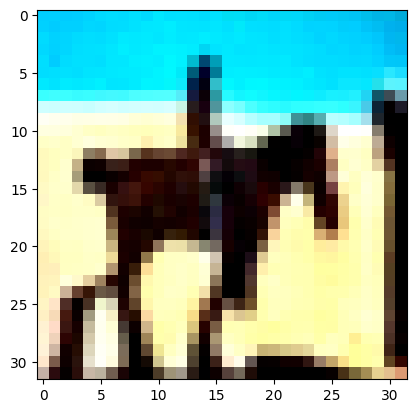

In [70]:
image = datasets.unnormalize_image(final_samples[0])
imageO = np.array(image, dtype=np.float32)
imageO = np.transpose(imageO, (1,2,0))
plt.imshow(imageO)
plt.show()